In [58]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

In [20]:
con = sqlite3.connect("data/gelbooru.db")
cur = con.cursor()
timeformat = "%Y-%m-%d %H:%M:%S"

In [21]:
## Create some useful views for the upcoming analysis.
# Create view that counts the tags grouped by its name.
cur.execute("CREATE TEMP VIEW tag_count AS " +
            "SELECT tag.id AS id, tag.name AS name, COUNT(tags.view) AS count " +
            "FROM tag JOIN tags ON tag.id = tags.tag " +
            "GROUP BY tag.name HAVING tag.name <> '1girl' AND tag.name <> 'solo'")
con.commit()

# General information

Tags used for searching: solo, 1girl, -comic, -4koma, -animated, -sound, -webm, -animated gif, -asian, -photo, -3d

## Some simple numbers

In [22]:
cur.execute("SELECT * FROM view ORDER BY id ASC LIMIT 1")
first_entry = cur.fetchone()
cur.execute("SELECT * FROM view ORDER BY id DESC LIMIT 1")
last_entry = cur.fetchone()
cur.execute("SELECT COUNT(*) FROM view")
total_count = cur.fetchone()[0]
cur.execute("SELECT COUNT(*) FROM tag")
tag_count = cur.fetchone()[0]

In [23]:
print("Id of first post: {} (from {})".format(first_entry[0], first_entry[1]))
print("Id of last post: {} (from {})".format(last_entry[0], last_entry[1]))
timedelta = datetime.strptime(last_entry[1], timeformat) - datetime.strptime(first_entry[1], timeformat)
print("Total count: {} (spanning {} days)".format(total_count, timedelta.days))
print("Number of tags: {}".format(tag_count))

Id of first post: 5 (from 2007-07-16 00:20:00)
Id of last post: 3150000 (from 2016-04-26 03:00:24)
Total count: 1212463 (spanning 3207 days)
Number of tags: 213432


## Distribution of posts

In [56]:
cur.execute("SELECT rating.name, COUNT(view) FROM rates JOIN rating ON rates.rating = rating.id GROUP BY rating")
dist_ratings = cur.fetchall()

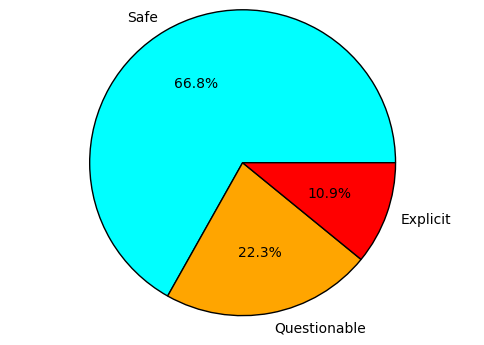

In [107]:
plt.pie([x[1] for x in dist_ratings], labels=[x[0] for x in dist_ratings], 
        colors=["cyan", "orange", "red"], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [140]:
id_list = []
for year in range(2007, 2016 + 1):
    year = format(year, "04")
    for month in range(1, 12 + 1):
        month = format(month, "02")
        cur.execute("SELECT id, SUBSTR(posted, 1, 4),  SUBSTR(posted, 6, 2) FROM view " +
                    "WHERE SUBSTR(posted, 1, 4) = ? AND  SUBSTR(posted, 6, 2) = ?" +
                    "ORDER BY id ASC LIMIT 1", (year, month))
        first_id = cur.fetchone()
        cur.execute("SELECT id, SUBSTR(posted, 1, 4),  SUBSTR(posted, 6, 2) FROM view " +
                    "WHERE SUBSTR(posted, 1, 4) = ? AND  SUBSTR(posted, 6, 2) = ?" +
                    "ORDER BY id DESC LIMIT 1", (year, month))
        last_id = cur.fetchone()
        if first_id and last_id:
            id_list.append((first_id[0], last_id[0]))

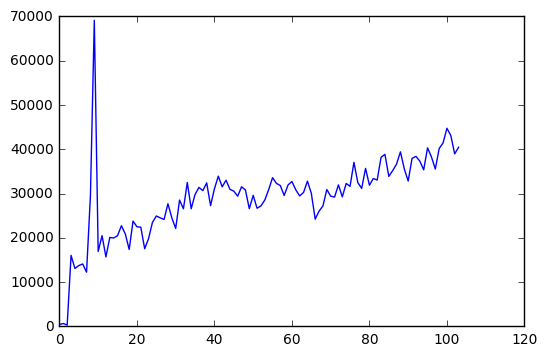

In [141]:
plt.plot([x[1] - x[0] for x in id_list][1:-1])
plt.show()

# Tag analysis

Goal: Find appropriate tags for automatic tagging with neural network.

In [29]:
cur.execute("SELECT tag_count.name, tag_count.count, tag_type.name " +
            "FROM tag_count JOIN categorizes ON tag_count.id = categorizes.tag " +
            "JOIN tag_type ON tag_type.id = categorizes.tag_type " +
            "WHERE count > 10000 ORDER BY count DESC")
top_tags = cur.fetchall()

In [73]:
print("{0:10} {1:>35} - {2:>6}".format("TYPE", "TAG NAME", "COUNT"))
print("-------------------------------------------------------")
for entry in top_tags:
    print("{0[2]:10} {0[0]:>35} - {0[1]:6d}".format(entry))
print("IN TOTAL:", len(top_tags), "TAGS")

TYPE                                  TAG NAME -  COUNT
-------------------------------------------------------
general                              long hair - 562353
general                                breasts - 474336
general                                  blush - 384920
general                                highres - 367095
general                                 female - 321347
general                                  smile - 309188
general                             short hair - 303731
general                      looking at viewer - 287483
copyright                               touhou - 267455
general                              blue eyes - 240885
general                             open mouth - 238594
general                                  skirt - 225126
general                             thighhighs - 218767
general                            blonde hair - 211997
general                               red eyes - 195450
general                             brown hair -

In [76]:
tag_count = np.array([entry[1] for entry in top_tags])
print("Mean:", np.mean(tag_count))
print("Standard derivation:", np.std(tag_count))

Mean: 46622.5972973
Standard derivation: 67171.8349073


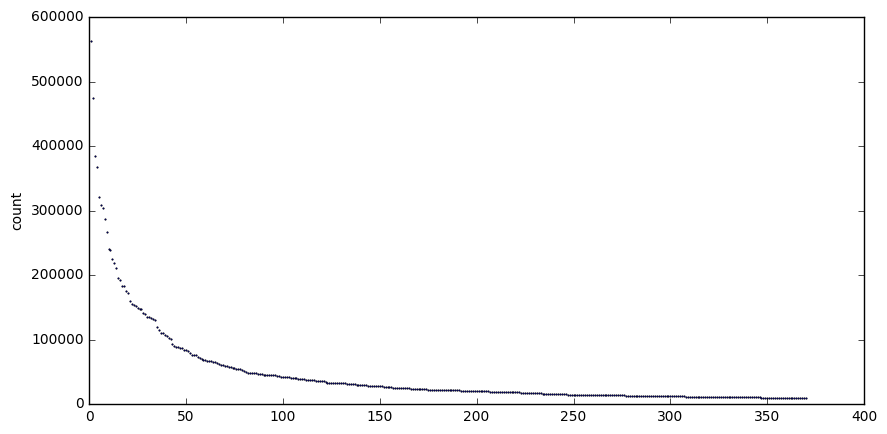

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(tag_count) + 1), tag_count, "bo", markersize=1)
plt.ylabel("count")
plt.show()